In [1]:
import cv2
import skimage.io as io
import numpy as np
from zipfile import ZipFile
import pandas as pd
import torch
import helper as helper

In [2]:
label_path='../labels/coco/labels/train2017/000000371735.txt'
with open(label_path) as box:
    box=box.read()
    box=pd.DataFrame([x.split() for x in box.rstrip('\n').split('\n')],columns=['class','xc','yc','w','h'])

b= box.values.astype(np.float32)
b=torch.tensor(b)
labels = b.T[0].reshape(b.shape[0], 1)
one_hot_target = (labels == torch.arange(80).reshape(1, 80)).float()
conf=torch.ones([b.shape[0],1])
boxes=torch.cat((b.T[1:],conf.T,one_hot_target.T)).T

img_path='../images/train2017/000000371735.jpg'
img=cv2.imread(img_path)[:,:,::-1] 

sample={'images': img,
        'boxes': boxes}


In [3]:
diff=1
import random
print(random.uniform(1,2))
def scale(sample):
    
    img=sample['images']
    bboxes=sample['boxes']
#Chose a random digit to scale by 
    angle = 0.2

    w,h = img.shape[1], img.shape[0]
    cx, cy = w//2, h//2

    img = helper.rotate_im(img, angle)

    corners = helper.get_corners(bboxes)

#     corners = torch.stack((corners, bboxes[:,4:]),dim=0)


    corners[:,:8] = helper.rotate_box(corners[:,:8], angle, cx, cy, h, w)

    new_bbox = helper.get_enclosing_box(corners)


    scale_factor_x = img.shape[1] / w

    scale_factor_y = img.shape[0] / h

    img = cv2.resize(img, (w,h))

    new_bbox[:,:4] /= [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 

    bboxes  = new_bbox

    bboxes = clip_box(bboxes, 0.25)

    return img, bboxes

1.1723660590720693


In [90]:
torch.rand([1])

tensor([0.3962])

In [4]:
import cv2 
import pickle as pkl
import numpy as np 
import matplotlib.pyplot as plt

def draw_rect(im, cords, color = None):
    """Draw the rectangle on the image
    
    Parameters
    ----------
    
    im : numpy.ndarray
        numpy image 
    
    cords: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    Returns
    -------
    
    numpy.ndarray
        numpy image with bounding boxes drawn on it
        
    """
    
    im = im.copy()
    h=im.shape[0]
    w=im.shape[1]
    cords[:,0]=cords[:,0]*w
    cords[:,1]=cords[:,1]*h
    cords[:,2]=cords[:,2]*w
    cords[:,3]=cords[:,3]*h
    if not color:
        color = [255,255,255]
    for cord in cords:
        pt1, pt2 = (cord[0]-cord[2]/2, cord[1]-cord[3]/2) , (cord[0]+cord[2]/2, cord[1]+cord[3]/2)
               
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        im = cv2.rectangle(im.copy(), pt1, pt2, color, int(max(im.shape[:2])/200))
    return im

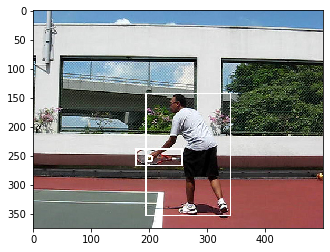

In [5]:
plt.imshow(draw_rect(sample['images'], sample['boxes']))

In [5]:
img, bboxes = scale(sample)

plt.imshow(draw_rect(img, bboxes))


torch.Size([3, 8])
torch.Size([12, 2])
torch.Size([2, 3])


RuntimeError: The size of tensor a (3) must match the size of tensor b (12) at non-singleton dimension 1

In [6]:
print(helper.get_corners(bboxes))

tensor([[253.0580, 186.2379, 442.5850, 186.2379, 253.0580, 459.0171, 442.5850,
         459.0171],
        [256.5680, 327.0932, 266.9550, 327.0932, 256.5680, 336.9861, 266.9550,
         336.9861],
        [231.1790, 309.6598, 333.3200, 309.6598, 231.1790, 347.9709, 333.3200,
         347.9709]])


In [ ]:
import torch

a=torch.tensor([[[1,2,2,4,0,0,0,1],[2,3,5,3,0,0,1,0]]])
print(a.shape)
b=((a[:,:,4:]==1).nonzero())
b=b[:,-1].unsqueeze(0).unsqueeze(-1)
print(b.shape)
new=a[:,:,:4]
print(new.shape)
new=torch.cat((new.T,b.T)).T
print(new)
sorted_pred=torch.sort(new[0,:,4],descending=False)
print(sorted_pred)

In [ ]:
b = box.values.astype(np.float32)
b=torch.tensor(b)
labels = b.T[0].reshape(b.shape[0], 1)
one_hot_target = (labels == torch.arange(80).reshape(1, 80)).float()
conf=torch.ones([b.shape[0],1])
boxes=torch.cat((b.T[1:],conf.T,one_hot_target.T)).T




In [ ]:
file_name='images/train2017.zip'
with ZipFile(file_name, 'r') as zip:
    image=zip.read('train2017/000000408542.jpg')
    img = cv2.imdecode(np.frombuffer(image, np.uint8),1)
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    io.imshow(im_rgb)
    io.imsave('fig.png',im_rgb)

In [ ]:
df=pd.read_csv('pointers/train2017.txt',names=['filename'])

In [ ]:
df['box']=df['filename'].apply(lambda x: 'coco/labels/'+x.split('.')[0]+'.txt')

In [ ]:
df['box']

In [1]:
from dataset import *
import timeit 
import cv2
import numpy as np
from zipfile import ZipFile
import pandas as pd
import torch
import time
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim

import sys
import timeit
import torch.autograd
import helper as helper
from torch.utils.tensorboard import SummaryWriter



net = Darknet("../cfg/yolov3.cfg")
inp_dim=net.inp_dim
pw_ph=net.pw_ph.to(device='cuda')
cx_cy=net.cx_cy.to(device='cuda')
stride=net.stride.to(device='cuda')


# idf_weights=pd.read_csv('../idf.csv')


hyperparameters={'lr':0.0001,
                 'batch_size':20,
                 'weight_decay':0.001,
                 'momentum':0.9,
                 'optimizer':'sgd',
                 'alpha':0.5,
                 'gamma':0,
                 'lcoord':5,
                 'lno_obj':1,
                 'iou_type':(0,0,0),#(GIoU,DIoU,CIoU) default is 0,0,0 for iou
                 'iou_ignore_thresh':0.5,
                 'tfidf':True,
                 'idf_weights':True,
                 'workers':2,
                 'path':'pretrained20_no_sm',
                 'reduction':'sum'}


if (hyperparameters['idf_weights']==True):
    hyperparameters['idf_weights']=pd.read_csv('../idf.csv')
else:
    hyperparameters['idf_weights']=False
        

'''
when loading weights from dataparallel model then, you first need to instatiate the dataparallel model 
if you start fresh then first model.load_weights and then make it parallel
'''
try:
    PATH = '../'+hyperparameters['path']+'.pth'
    weights = torch.load(PATH)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we https://pytorch.org/docs/stable/data.html#torch.utils.data.Datasetare on a CUDA machine, this should print a CUDA device:
    print(device)
    net.to(device)

    if (torch.cuda.device_count() > 1):
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
        model.to(device)
        model.load_state_dict(weights)
    else:
        model=net
        model.to(device)
        model.load_state_dict(weights)
        
except FileNotFoundError: 
    net.load_weights("../yolov3.weights")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:

    print(device)
    net.to(device)
    if (torch.cuda.device_count() > 1):
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
        model.to(device)
    else:
        model=net
        

transformed_dataset=Coco(partition='train',
                                           transform=transforms.Compose([
                                            ResizeToTensor(inp_dim),
                                           ]))


writer = SummaryWriter('../results/'+hyperparameters['path'])
dataset_len=(len(transformed_dataset))
print('Length of dataset is '+ str(dataset_len)+'\n')
batch_size=hyperparameters['batch_size']
dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=True,collate_fn=helper.my_collate, num_workers=hyperparameters['workers'])


if hyperparameters['optimizer']=='sgd':
    optimizer = optim.SGD(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'], momentum=hyperparameters['momentum'])
elif hyperparameters['otimizer']=='adam':
    optimizer = optim.Adam(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'])

lambda1 = lambda epoch: 0.95**epoch
scheduler=optim.lr_scheduler.LambdaLR(optimizer, lambda1, last_epoch=-1)

epochs=50
total_loss=0
write=0
misses=0
avg_iou=0
for e in range(epochs):
    prg_counter=0
    train_counter=0
    total_loss=0
    avg_iou=0
    avg_infs=0
    avg_conf=0
    avg_no_conf=0
    avg_pos=0
    avg_neg=0
    print("\n epoch "+str(e))
    misses=0
    for images,targets,img_names in dataloader:
        optimizer.zero_grad()
        targets,anchors,offset,strd,mask=helper.collapse_boxes(targets,pw_ph,cx_cy,stride)
        images=images.cuda()
        raw_pred = model(images, torch.cuda.is_available())
        raw_pred=helper.expand_predictions(raw_pred,mask)
        true_pred=util.transform(raw_pred.clone(),anchors,offset,strd)
        targets=targets.unsqueeze(-3)
        targets=targets.cuda()
        iou_mask,noobj_mask=util.get_responsible_masks(true_pred,targets,offset,strd,mask,inp_dim,hyperparameters)
        
        iou1=torch.diag(util.bbox_iou(util.get_abs_coord(true_pred[iou_mask.T,:].unsqueeze(-3)),util.transpose_target(get_abs_coord(targets)*inp_dim),hyperparameters['iou_type']))
        iou=iou1.mean().item()
        noobj_box=raw_pred[:,:,4:5].clone()
        noobj_box=helper.uncollapse(noobj_box,mask)
        noobj_mask=helper.uncollapse(noobj_mask.T.unsqueeze(-1),mask)
        
        
        conf=raw_pred[iou_mask.T,:][:,4:5].mean().item()
        class_mask=targets[:,:,5:].type(torch.BoolTensor).squeeze(0)
        if(iou_mask.sum()==class_mask.shape[0]):
            pos_class=raw_pred[iou_mask.T,:][:,5:][class_mask].mean().item()
            neg_class=raw_pred[iou_mask.T,:][:,5:][~class_mask].mean().item()
        else:
            pos_class=0
            neg_class=0
            
        noobj_box=noobj_box[noobj_mask]
        no_obj_conf=noobj_box.mean().item()
        
        raw_pred=raw_pred[iou_mask.T,:]
        anchors=anchors[iou_mask.T,:]
        offset=offset[iou_mask.T,:]
        strd=strd[iou_mask.T,:]
        
        if(strd.shape[0]==sum(mask)):#this means that iou_mask failed and was all true, because max of zeros is true for all lenght of mask strd
            targets[:,:,0:4]=targets[:,:,0:4]*inp_dim
            targets=targets.squeeze(0)
            targets[:,0:4]=util.transform_groundtruth(targets,anchors,offset,strd)
            with torch.autograd.set_detect_anomaly(True):
                loss=util.yolo_loss(raw_pred,targets,noobj_box,mask,hyperparameters)
                loss.backward()
                optimizer.step()
            
            avg_conf=avg_conf+conf
            avg_no_conf=avg_no_conf+no_obj_conf
            avg_pos=avg_pos+pos_class
            avg_neg=avg_neg+neg_class
            total_loss=total_loss+loss.item()
            avg_iou=avg_iou+iou
            sys.stdout.write('\rPgr:'+str(prg_counter/dataset_len*100*batch_size)+'%' ' L:'+ str(loss.item()))
            sys.stdout.write(' IoU:' +str(iou)+' pob:'+str(conf)+ ' nob:'+str(no_obj_conf))
            sys.stdout.write(' PCls:' +str(pos_class)+' ncls:'+str(neg_class))
            sys.stdout.flush()
            prg_counter=prg_counter+1
            train_counter=train_counter+1
        else:
            print('missed')
            print(strd.shape[0])
            prg_counter=prg_counter+1
        iou1=iou1.tolist()
        iou_per_class= [0] * 80
        averager_per_class=[1] * 80
        for i,el in enumerate(iou1):
            name=targets[i,5:].max(0)[1].cpu().detach().numpy()
            iou_per_class[name]=iou_per_class[name]+el
            averager_per_class[name]=averager_per_class[name]+1
        for i in range(80):
            if (iou_per_class[i]!=0):
                if i<40:
                    writer.add_scalar('Iou0/'+str(i), iou_per_class[i]/averager_per_class[i], train_counter)
                else:
                    writer.add_scalar('Iou1/'+str(i), iou_per_class[i]/averager_per_class[i], train_counter)
        writer.add_scalar('AvLoss/train', total_loss/train_counter, train_counter)

        
        writer.add_scalar('AvIoU/train', avg_iou/train_counter, train_counter)

        writer.add_scalar('AvPConf/train', avg_conf/train_counter, train_counter)
        
        writer.add_scalar('AvNConf/train', avg_no_conf/train_counter, train_counter)
        
        writer.add_scalar('AvClass/train', avg_pos/train_counter, train_counter)
        
        writer.add_scalar('AvNClass/train', avg_neg/train_counter, train_counter)
        
        del loss, raw_pred, targets, true_pred, images,iou,noobj_box,conf,iou1
        torch.cuda.empty_cache()
    if misses>0:
        break
#     torch.save(model.state_dict(), PATH)
#     writer.add_scalar('Loss/train', total_loss/train_counter, e)
#     writer.add_scalar('AIoU/train', avg_iou/train_counter, e)
#     writer.add_scalar('PConf/train', avg_conf/train_counter, e)
#     writer.add_scalar('NConf/train', avg_no_conf/train_counter, e)
#     writer.add_scalar('PClass/train', avg_pos/train_counter, e)
#     writer.add_scalar('NClass/train', avg_neg/train_counter, e)
    print('\ntotal number of misses is ' + str(misses))
    print('\n total average loss is '+str(total_loss/train_counter))
    print('\n total average iou is '+str(avg_iou/train_counter))

cuda:0
Using  2 GPUs!
Length of dataset is 118287


 epoch 0


/users/konsa15/.conda/envs/faster_rcnn/lib/python3.8/site-packages/torch/nn/functional.py:2503: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


Pgr:0.2874364892169046% L:2.5664230588026626 IoU:0.7830198407173157 pob:0.695453941822052 nob:0.0010570075828582048 PCls:0.9564895629882812 ncls:0.00055076577700674537

RuntimeError: CUDA out of memory. Tried to allocate 778.00 MiB (GPU 0; 7.93 GiB total capacity; 6.85 GiB already allocated; 430.38 MiB free; 7.01 GiB reserved in total by PyTorch)

In [2]:
torch.save(model.state_dict(), PATH)

In [6]:
import torch
a=torch.tensor([0.93,0.35])
print(torch.softmax(a,dim=0))

tensor([0.6411, 0.3589])


In [9]:
test=torch.tensor([[[1,2],[3,4]]])
print(test.shape[1:])

torch.Size([2, 2])


In [23]:
print(mask)

idf=torch.stack([targets[:i,5:].sum(axis=0) for i in mask],dim=0)
idf[idf>1]=1

print(idf.sum(axis=0))

[4, 3, 12, 5, 2, 1, 6, 3, 8, 3, 4, 11, 19, 16, 3, 6]
tensor([10.,  4., 15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
         0.,  0., 16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  8.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])


In [68]:

tf=torch.tensor([1/mask[i] for i in range(len(mask)) for j in range(mask[i])]).cuda()

classes=targets[:,5:].max(1)[1]
print(classes)
# print(obj_idf)
# print(classes.tolist())
idf=np.array(obj_idf['obj_idf'][classes.tolist()])
idf=torch.tensor(idf,device='cuda')
idf=-torch.log(idf)
tfidf=tf*idf
print(tfidf)
tfidf=torch.softmax(tfidf,dim=0)
print(tfidf)

tensor([15, 66,  0,  0,  0,  0,  0, 30, 30,  9,  9,  9,  9, 24,  0,  0,  0, 30,
         0,  0,  0,  0, 30, 30,  0, 37, 23, 23,  4,  0,  6,  0,  0, 37, 17,  0,
         0, 17,  0, 19, 19, 19,  0, 20, 20, 32,  0,  0,  0,  0, 35, 35, 35,  1,
         1,  1,  1,  1, 24, 17,  0, 17, 15, 67, 63, 73, 76, 60, 45, 60, 52, 48,
         0,  0,  0, 11,  2,  7], device='cuda:0')
tensor([2.2617, 2.8482, 0.0543, 0.0543, 0.0543, 0.0543, 0.0543, 0.2211, 0.2211,
        0.1924, 0.1924, 0.1924, 0.1924, 0.2135, 0.0543, 0.0543, 0.0543, 0.2211,
        0.0543, 0.0543, 0.0543, 0.0543, 0.2211, 0.2211, 0.5976, 2.4636, 2.3481,
        2.3481, 1.7821, 0.5976, 1.9959, 0.5976, 0.5976, 2.4636, 0.9140, 0.2390,
        0.2390, 0.9140, 0.2390, 1.5290, 1.5290, 1.5290, 0.3984, 1.5299, 1.5299,
        0.6107, 0.1494, 0.1494, 0.1494, 0.1494, 0.6131, 0.6131, 0.6131, 0.4953,
        0.4953, 0.4953, 0.4953, 0.4953, 0.7827, 1.5234, 0.3984, 1.5234, 0.6462,
        0.8227, 0.7916, 0.8746, 0.9268, 0.7589, 0.7150, 0.8853, 0.8517

In [ ]:
targets2,anchors,offset,strd,mask=helper.collapse_boxes(targets,pw_ph,cx_cy,stride)
transformed_output=true_pred
targets=targets
offset=offset
strd=strd
mask=mask
inp_dim
'''
this function takes the transformed_output and
the target box in respect to the resized image size
and returns a mask which can be applied to select the 
best raw input,anchors and cx_cy_offset
and the noobj_mask for the negatives
targets is a list
'''
#first transpose the centered normalised target coords
centered_target=transpose_target(targets)[:,:,0:2]
#multiply by inp_dim then devide by stride to get the relative grid size coordinates, floor the result to get the corresponding cell
centered_target=torch.floor(centered_target*inp_dim/strd)
#create a mask to find where the gt falls into which gridcell in the grid coordinate system
fall_into_mask=centered_target==offset
fall_into_mask=fall_into_mask[:,:,0]&fall_into_mask[:,:,1]
#     fall_into_mask= ~fall_into_mask
#create a copy of the transformed output
best_bboxes=transformed_output.clone()
#apply reverse mask to copy in order to zero all other bbox locations
best_bboxes[~fall_into_mask]=0   
#transform the copy to xmin,xmax,ymin,ymax
best_responsible_coord=get_abs_coord(best_bboxes)
targets=transpose_target(get_abs_coord(targets))*inp_dim
#calculate best iou and mask
responsible_iou=bbox_iou(best_responsible_coord,targets,True)

responsible_iou[responsible_iou.ne(responsible_iou)] = 0
responsible_mask=responsible_iou.max(dim=0)[0] == responsible_iou

print(responsible_mask.shape)

abs_coord=get_abs_coord(transformed_output)
iou=bbox_iou(abs_coord,targets,True)
iou[iou.ne(iou)] = 0
ignore_mask=0.5<=iou
inverted_mask=iou.max(dim=0)[0] != iou
noobj_mask=~same_picture_mask(responsible_mask.clone()|ignore_mask,mask)

In [ ]:
print(responsible_mask)
if(responsible_mask.sum()>sum(mask)):
    print('jello')
    responsible_mask1=correct_iou_mask(responsible_mask,fall_into_mask)
print(responsible_mask1.shape)

In [ ]:
a=torch.randint(0, 9, (1,)) == torch.arange(9)
a=a.repeat(5)
a=a.repeat(2,1)
print(a)
print(a.T)

In [15]:
hyperparameters={'lr':0.01,'batch_size':16,'weight_decay':0.001,'optimizer':'sgd','alpha':0.5,'gamma':2,'iou_ignore_thresh':0.5,'tfidf':True,'reduction':'sum'}

In [ ]:
le_mask=(responsible_mask.sum(axis=0)==responsible_mask.sum(axis=0).max())

In [ ]:
responsible_mask[:,le_mask]=(responsible_mask[:,le_mask]&fall_into_mask[le_mask,:].T)

In [ ]:
print(le_mask)
print(fall_into_mask[le_mask,:].shape)


In [ ]:
a=torch.tensor([1,2,3,4,5,6,6,6])
indices=(((a==a.max())==True).nonzero())
for ind in indices:
    print(ind)

In [1]:
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim
import pandas as pd
import time
import sys
import timeit
from dataset import *
import torchvision.ops.boxes as nms_box
import helper as helper
from utils import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes


net = Darknet("../cfg/yolov3.cfg")
inp_dim=net.inp_dim
pw_ph=net.pw_ph
cx_cy=net.cx_cy
stride=net.stride

start_time = time.time()
'''
when loading weights from dataparallel model then, you first need to instatiate the dataparallel model 
if you start fresh then first model.load_weights and then make it parallel
'''
try:
    PATH = '../pretrained20.pth'
    weights = torch.load(PATH)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:
    print(device)
    net.to(device)

    if torch.cuda.device_count() > 1:
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
    else:
        model=net

    model.to(device)
    
    
    model.load_state_dict(weights)
    model.eval()
except FileNotFoundError: 
    net.load_weights("../yolov3.weights")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:

    print(device)
    net.to(device)
    if torch.cuda.device_count() > 1:
      print("Using ", torch.cuda.device_count(), "GPUs!")
      model = nn.DataParallel(net)

    model.to(device)
    model.eval()




print('testing with '+ PATH +'\n')
transformed_dataset=Coco(partition='val',
                                           transform=transforms.Compose([
                                            ResizeToTensor(inp_dim)
                                           ]))



dataset_len=(len(transformed_dataset))
print('Length of dataset is '+ str(dataset_len)+'\n')
batch_size=16

dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=True,collate_fn=helper.my_collate, num_workers=4)

true_pos=0
false_pos=0
counter=0
iou_threshold=0.5
confidence=0.01
recall_counter=0
max_detections=None

for images,targets,img_name in dataloader:
    inp=images.cuda()
    raw_pred = model(inp, torch.cuda.is_available())
    targets,anchors,offset,strd,mask=helper.collapse_boxes(targets,pw_ph,cx_cy,stride)
    raw_pred=raw_pred.to(device='cuda')
    true_pred=util.transform(raw_pred.clone(),pw_ph,cx_cy,stride)
    
    classes=true_pred[:,:,5:].max(2)[0]
    objectness=true_pred[:,:,4]
    
    sorted_pred=torch.sort(objectness,descending=True)
    pred_mask=sorted_pred[0]>confidence
    indices=[(sorted_pred[1][e,:][pred_mask[e,:]]) for e in range(pred_mask.shape[0])]
    pred_final=[true_pred[i,indices[i],:] for i in range(len(indices))]
    
    pred_final_coord=[util.get_abs_coord(pred_final[i].unsqueeze(-2)) for i in range(len(pred_final))]
    
    indices=[nms_box.nms(pred_final_coord[i][0],pred_final[i][:,4],iou_threshold) for i in range(len(pred_final))]

    pred_final=[pred_final[i][indices[i],:] for i in range(len(pred_final))]
#     pred_final[:,0:4]=pred_final[:,0:4]/inp_dim
    helper.write_pred(img_name,pred_final,inp_dim,max_detections)
    

print("--- %s seconds ---" % (time.time() - start_time))

# Read txt files containing bounding boxes (ground truth and detections)


cuda:0
Using  2 GPUs!
testing with ../pretrained20.pth

Length of dataset is 5000



/users/konsa15/.conda/envs/faster_rcnn/lib/python3.8/site-packages/torch/nn/functional.py:2503: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


--- 107.62120389938354 seconds ---


In [ ]:
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim
import pandas as pd
import time
import sys
import timeit
from dataset import *
import torchvision.ops.boxes as nms_box
import helper as helper
from utils import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes
boundingboxes = helper.getBoundingBoxes()


In [2]:
from Evaluator import *
from utils import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes


boundingboxes = helper.getBoundingBoxes()
evaluator = Evaluator()

iou=0.5
MMap=0
while iou<1:
    metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=iou)
#     print("Average precision values per class:\n")
    # Loop through classes to obtain their metrics
    mAP=0
    counter=0
    for mc in metricsPerClass:
        # Get metric values per each class
        c = mc['class']
        precision = mc['precision']
        recall = mc['recall']
        average_precision = mc['AP']
        ipre = mc['interpolated precision']
        irec = mc['interpolated recall']
        # Print AP per class
        mAP=average_precision+mAP
#         print('%s: %f' % (c, average_precision))
    MMap=MMap+mAP/80
    iou=iou+0.05
    print('\nCOCO map is:',MMap)


COCO map is: 0.6775532157036954

COCO map is: 1.326182282206649

COCO map is: 1.9345290514389095

COCO map is: 2.491104096370508

COCO map is: 2.977692628476223

COCO map is: 3.372420338853471

COCO map is: 3.6633399530230797

COCO map is: 3.8353732828668297

COCO map is: 3.890211545189467

COCO map is: 3.893089384121989


In [5]:
0.6403413112473646
0.6503946905414258
for mc in metricsPerClass:
    c = mc['class']
    average_precision = mc['AP']
    print('%s: %f' % (c, average_precision))

0: 0.001576
1: 0.000500
10: 0.000194
11: 0.000000
12: 0.000000
13: 0.003635
14: 0.000061
15: 0.003767
16: 0.007893
17: 0.001253
18: 0.002096
19: 0.003806
2: 0.001995
20: 0.002062
21: 0.019332
22: 0.005166
23: 0.001213
24: 0.000123
25: 0.000791
26: 0.001165
27: 0.000106
28: 0.000452
29: 0.006250
3: 0.000064
30: 0.000189
31: 0.000000
32: 0.005474
33: 0.002095
34: 0.001349
35: 0.000322
36: 0.001117
37: 0.000121
38: 0.000508
39: 0.000694
4: 0.003233
40: 0.002795
41: 0.002764
42: 0.000034
43: 0.000083
44: 0.000000
45: 0.005726
46: 0.001819
47: 0.000814
48: 0.000644
49: 0.004769
5: 0.007732
50: 0.000000
51: 0.000424
52: 0.000000
53: 0.009787
54: 0.001989
55: 0.000344
56: 0.000159
57: 0.008519
58: 0.000000
59: 0.003829
6: 0.002898
60: 0.001310
61: 0.004003
62: 0.001842
63: 0.002337
64: 0.009707
65: 0.001246
66: 0.000000
67: 0.009142
68: 0.000000
69: 0.000194
7: 0.002832
70: 0.000000
71: 0.003943
72: 0.002155
73: 0.000207
74: 0.000342
75: 0.000999
76: 0.002137
77: 0.000277
78: 0.000000
79: 0.0

In [6]:
print(MMap/10)

0.3651112345706164


In [7]:
print('%s: %f' % (c, average_precision))

9: 0.000231


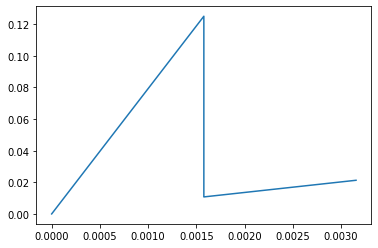

In [4]:
import matplotlib.pyplot as plt

plt.plot(recall, precision)

In [ ]:
from Evaluator import *
evaluator = Evaluator()
metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=0.5)
print("Average precision values per class:\n")
# Loop through classes to obtain their metrics
mAP=0
counter=0
for mc in metricsPerClass:
    # Get metric values per each class
    c = mc['class']
    precision = mc['precision']
    recall = mc['recall']
    average_precision = mc['AP']
    ipre = mc['interpolated precision']
    irec = mc['interpolated recall']
    # Print AP per class
    mAP=average_precision+mAP
    print('%s: %f' % (c, average_precision))

print('map is:',mAP/80)

In [ ]:
0.07290217209136615

In [ ]:
import pandas as pd
coord=pred_final[:,:4].cpu().detach().numpy()
conf=pred_final[:,4:5].cpu().detach().numpy()
mat=np.hstack((conf,coord))

classes=pred_final[:,5:].max(1)[1].cpu().detach().numpy()
classes=np.array([classes]).T

mat=np.hstack((classes,mat))
mat=np.array(mat)

df=pd.DataFrame(mat,index=None,columns=None)
df[0]=df[0].apply(lambda x: int(x))

df.to_csv('test.txt',sep=' ',header=False,index=None)

In [ ]:
np.savetxt('test.txt',mat)

In [ ]:
a=torch.tensor([1,2,2,3,4,2,3,1,4])
print(a.max(0))

In [ ]:
import skimage.io as io

In [ ]:
image=(inp).squeeze(0)
image=np.array(image.cpu())
print(image.shape)
image =  image[:,:,::-1].transpose((1,2,0))
print(image.shape)

In [ ]:
import pandas as pd
import glob

all_files = glob.glob('plots/' + "/*.csv")

li = []

for filename in sorted(all_files):
    print(filename)
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=1, ignore_index=True)


In [10]:
df=pd.read_csv('../pointer.csv')
print(df)

        Unnamed: 0                         img  \
0                0  train2017/000000109622.jpg   
1                1  train2017/000000160694.jpg   
2                2  train2017/000000308590.jpg   
3                3  train2017/000000327573.jpg   
4                4  train2017/000000062929.jpg   
...            ...                         ...   
118281      118282  train2017/000000421432.jpg   
118282      118283  train2017/000000299290.jpg   
118283      118284  train2017/000000119428.jpg   
118284      118285  train2017/000000148101.jpg   
118285      118286  train2017/000000337779.jpg   

                                           box  
0       coco/labels/train2017/000000109622.txt  
1       coco/labels/train2017/000000160694.txt  
2       coco/labels/train2017/000000308590.txt  
3       coco/labels/train2017/000000327573.txt  
4       coco/labels/train2017/000000062929.txt  
...                                        ...  
118281  coco/labels/train2017/000000421432.txt  
118282 

In [11]:
df=df[:None]
print(df)

        Unnamed: 0                         img  \
0                0  train2017/000000109622.jpg   
1                1  train2017/000000160694.jpg   
2                2  train2017/000000308590.jpg   
3                3  train2017/000000327573.jpg   
4                4  train2017/000000062929.jpg   
...            ...                         ...   
118281      118282  train2017/000000421432.jpg   
118282      118283  train2017/000000299290.jpg   
118283      118284  train2017/000000119428.jpg   
118284      118285  train2017/000000148101.jpg   
118285      118286  train2017/000000337779.jpg   

                                           box  
0       coco/labels/train2017/000000109622.txt  
1       coco/labels/train2017/000000160694.txt  
2       coco/labels/train2017/000000308590.txt  
3       coco/labels/train2017/000000327573.txt  
4       coco/labels/train2017/000000062929.txt  
...                                        ...  
118281  coco/labels/train2017/000000421432.txt  
118282 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# gca stands for 'get current axis'

title_list=['AIoU_train','Loss_train','NClass_train','NConf_train','PClass','PConf']

fig = plt.figure(figsize=(30, 10))
fig.suptitle('KL for xy loss')
fig.subplots_adjust(hspace=0.3, wspace=-.6)
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
i=2
k=0
while i <18:
    ax = fig.add_subplot(2, 9, i)
    frame.plot(x =1 , y = i,ax=ax,legend=False)
    ax.set_title(title_list[k])
    i=i+3
    k=k+1
plt.savefig('original.png')
plt.show()

In [6]:
import os
import pandas as pd
import glob
import sys


df = pd.DataFrame(columns=['class','xc','yc','w','h','filename'])
os.chdir('/mnt/data1/users/konsa15/workspace/notebooks/coco/labels/coco/labels/val2017')
print(os.getcwd())
files = glob.glob("*.txt")
dataset_len=len(files)
prg_counter=0
print(dataset_len)
for file in files:
    with open(file) as f:
        f=f.read()
        box=pd.DataFrame([x.split() for x in f.rstrip('\n').split('\n')],columns=['class','xc','yc','w','h'])
        box['filename']=[file for x in f.rstrip('\n').split('\n')]
        df = df.append(box, ignore_index = True)
        
    sys.stdout.write('\rPgr:'+str(prg_counter/dataset_len*100)+'%')
    prg_counter+=1

print(df)
obj_idf=(df['class'].value_counts(normalize=True).reset_index(name='obj_idf'))
new_df=df.groupby('filename')['class'].value_counts().reset_index(name='count')
img_idf=new_df['class'].value_counts(normalize=True).reset_index(name='img_idf')

obj_idf['img_idf']=img_idf['img_idf']


/mnt/data1/users/konsa15/workspace/notebooks/coco/labels/coco/labels/val2017
4952
Pgr:99.97980613893377%      class        xc        yc         w         h          filename
0        39  0.125266  0.228448  0.211750  0.450437  000000312192.txt
1        60  0.503383  0.590854  0.993234  0.783292  000000312192.txt
2         0  0.732789  0.245490  0.534422  0.442437  000000312192.txt
3        40  0.069102  0.310854  0.138203  0.532583  000000312192.txt
4        40  0.322680  0.081260  0.074203  0.150479  000000312192.txt
...     ...       ...       ...       ...       ...               ...
36330    73  0.464984  0.428341  0.018969  0.233785  000000571893.txt
36331    73  0.490781  0.439930  0.045188  0.219673  000000571893.txt
36332    73  0.585711  0.461519  0.040328  0.178131  000000571893.txt
36333    74  0.012438  0.348014  0.024875  0.036215  000000571893.txt
36334    73  0.474445  0.770257  0.018891  0.208879  000000571893.txt

[36335 rows x 6 columns]


In [4]:
import os
import pandas as pd
import glob
import sys


from multiprocessing import Pool # for reading the CSVs faster

def my_read_csv(filename):
    try:
        f=open(filename).read()
        box=pd.DataFrame([x.split() for x in f.rstrip('\n').split('\n')],columns=['class','xc','yc','w','h'])
        box['filename']=[filename for x in f.rstrip('\n').split('\n')]
        return box
    except FileNotFoundError:
        return None

def load_csvs():
    """Reads and joins all our CSV files into one big dataframe.
    We do it in parallel to make it faster, since otherwise it takes some time.
    Idea from: https://stackoverflow.com/questions/36587211/easiest-way-to-read-csv-files-with-multiprocessing-in-pandas
    
    """
    # set up your pool
    pool = Pool() 
    os.chdir('/mnt/data1/users/konsa15/workspace/notebooks/coco/labels/coco/labels/train2017')
    print(os.getcwd())
    files = os.listdir('.')
    file_list = [filename for filename in files if filename.split('.')[1]=='txt']
    print(len(file_list))
    df_list = pool.map(my_read_csv, file_list)
    # reduce the list of dataframes to a single dataframe
    return pd.concat(df_list, ignore_index=True)

In [5]:
df=load_csvs()

/mnt/data1/users/konsa15/workspace/notebooks/coco/labels/coco/labels/train2017
117266


In [7]:
print(df)
obj_idf=(df['class'].value_counts(normalize=True).reset_index(name='obj_idf'))
new_df=df.groupby('filename')['class'].value_counts().reset_index(name='count')
img_idf=new_df['class'].value_counts(normalize=True).reset_index(name='img_idf')

obj_idf['img_idf']=img_idf['img_idf']

       class        xc        yc         w         h          filename
0         30  0.786750  0.428354  0.259656  0.333833  000000196558.txt
1         30  0.208883  0.424271  0.142766  0.249333  000000196558.txt
2         30  0.533766  0.471438  0.148063  0.423375  000000196558.txt
3          0  0.500840  0.618733  0.998320  0.743813  000000538534.txt
4          0  0.208150  0.433707  0.382580  0.435947  000000538534.txt
...      ...       ...       ...       ...       ...               ...
849937    29  0.328891  0.372063  0.051219  0.027333  000000059442.txt
849938     0  0.765242  0.535833  0.198172  0.415708  000000059442.txt
849939     8  0.500000  0.297756  1.000000  0.595513  000000443835.txt
849940     0  0.451922  0.533929  0.719688  0.903804  000000443835.txt
849941    13  0.500641  0.688098  0.998719  0.623576  000000443835.txt

[849942 rows x 6 columns]


In [45]:
os.chdir('/mnt/data1/users/konsa15/workspace/notebooks/coco/yolo')


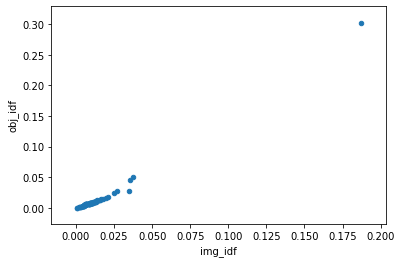

In [25]:
fig=obj_idf.plot(x='img_idf',y='obj_idf',kind='scatter').get_figure()
fig.savefig('obj_img_idf-corr.png')

In [26]:
obj_idf.corr()

,obj_idf,img_idf
obj_idf,1.000000,0.992497
img_idf,0.992497,1.000000


In [43]:
obj_idf

,index,obj_idf,img_idf
0,0,0.302670,0.186926
1,2,0.051216,0.037242
2,56,0.044795,0.035718
3,73,0.028328,0.034511
4,39,0.028320,0.026790
...,...,...,...
75,76,0.001722,0.002799
76,21,0.001522,0.002761
77,12,0.001510,0.002055
78,70,0.000265,0.000633
